In [29]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [30]:
import joblib
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
                                    StratifiedKFold,
                                    cross_validate,
                                    GridSearchCV
                                )
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            precision_score,
                            recall_score,
                            f1_score,
                            roc_auc_score,
                            roc_curve,
                            precision_recall_curve
                        )

warnings.filterwarnings('ignore')

#### Load the Data

In [31]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

#### Define Multimodels

In [32]:
lr_param_grid = {
    'max_iter' : [1000, 5000, 10000]
}

dt_param_grid = {
    'max_depth' : [8, 12, 16, 20],
    'criterion' : ['gini', 'entropy', 'log_loss']
}

rf_param_grid = {
    'n_estimators' : [50, 100],
    'max_depth' : [50, 100],
    'criterion' : ['gini', 'entropy', 'log_loss']
}

xgb_param_grid = {
    'n_estimators' : [100, 300, 500],
    'learning_rate' : [0.1, 0.01, 0.05],
    'max_depth' : [100, 200, 500]
}

param_grids = {
    'Logistic Regression' : lr_param_grid,
    'Decision Tree' : dt_param_grid,
    'Random Forest' : rf_param_grid,
    'XGBoost' : xgb_param_grid
}

In [33]:
models = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'XGBoost' : XGBClassifier()
}

#### Configure k-fold CV

In [34]:
cv = StratifiedKFold(
                    n_splits=6,
                    shuffle=True,
                    random_state=42
                )

#### Multimodel Training

In [35]:
grid_search_results = {}

for model_name, model in models.items():
    print(f'\n---------------Tuning {model_name}----------------')

    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
                                estimator=model,
                                param_grid=param_grid,
                                cv=cv, scoring='f1',
                                verbose=1, return_train_score=True
                            )
    
    print(f'Fitting gridSearchCV for {model_name}')
    grid_search.fit(X_train, Y_train)
    grid_search_results[model_name] = grid_search

    print(f'{model_name} gridSearchCV completed......')
    print(f'Best parameters : {grid_search.best_params_}')
    print(f'Best CV scores : {grid_search.best_score_}')


---------------Tuning Logistic Regression----------------
Fitting gridSearchCV for Logistic Regression
Fitting 6 folds for each of 3 candidates, totalling 18 fits
Logistic Regression gridSearchCV completed......
Best parameters : {'max_iter': 1000}
Best CV scores : 0.8005231362254244

---------------Tuning Decision Tree----------------
Fitting gridSearchCV for Decision Tree
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Decision Tree gridSearchCV completed......
Best parameters : {'criterion': 'log_loss', 'max_depth': 12}
Best CV scores : 0.8104086760097068

---------------Tuning Random Forest----------------
Fitting gridSearchCV for Random Forest
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Random Forest gridSearchCV completed......
Best parameters : {'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 100}
Best CV scores : 0.8540511415118731

---------------Tuning XGBoost----------------
Fitting gridSearchCV for XGBoost
Fitting 6 folds for each of

In [36]:
grid_search_results

{'Logistic Regression': GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
              estimator=LogisticRegression(),
              param_grid={'max_iter': [1000, 5000, 10000]},
              return_train_score=True, scoring='f1', verbose=1),
 'Decision Tree': GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
              estimator=DecisionTreeClassifier(),
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [8, 12, 16, 20]},
              return_train_score=True, scoring='f1', verbose=1),
 'Random Forest': GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(),
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [50, 100], 'n_estimators': [50, 100]},
              return_train_score=True, scoring='f1', verbose=1),
 'XGBoost': GridSearchCV(cv=Stra

In [37]:
best_model = grid_search.best_estimator_

In [38]:
Y_hat_test = best_model.predict(X_test)

In [39]:
accuracy = accuracy_score(Y_test, Y_hat_test)
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
f1 = f1_score(Y_test, Y_hat_test)

print(f'Accuracy : {accuracy}')
print(f'precision : {precision}')
print(f'recall : {recall}')
print(f'f1_score : {f1}')

Accuracy : 0.7686302342086586
precision : 0.5630026809651475
recall : 0.5630026809651475
f1_score : 0.5630026809651475


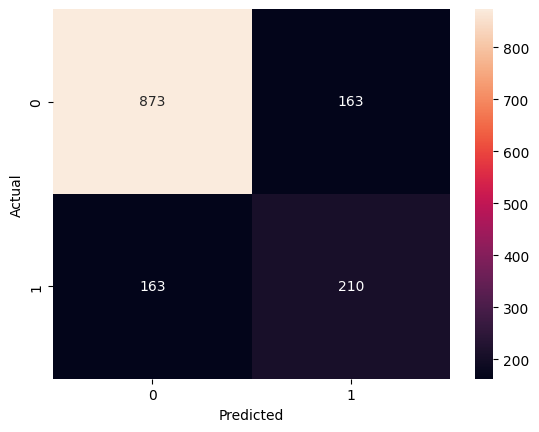

In [40]:
cm = confusion_matrix(Y_test, Y_hat_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()